In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.circuit.agnostic_circuits.circuit_manager import CircuitModeller
from synbio_morpher.utils.common.setup import construct_circuit_from_cfg, prepare_config
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.srv.io.manage.script_manager import script_preamble
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols

import os
import sys
import numpy as np
import jax.numpy as jnp
import jax

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

jax.config.update('jax_platform_name', 'gpu')


# if __package__ is None:

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

__package__ = os.path.basename(module_path)

rng = jax.random.PRNGKey(0)

jax.devices()



xla_bridge.py:backends():704: Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA INFO
xla_bridge.py:backends():704: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory INFO


[cuda(id=0)]

In [3]:
fn = '../data/processed/ensemble_mutation_effect_analysis/2023_07_17_105328/tabulated_mutation_info.csv'
fn_test_data = '../data/raw/ensemble_mutation_effect_analysis/2023_10_03_204819/tabulated_mutation_info.csv'
data = pd.read_csv(fn)
# data = pd.concat([pd.read_csv(fn), pd.read_csv(fn_test_data)])
# tdata = pd.read_csv(fn_test_data)
len(data)

1629000

In [4]:
try:
    data = data.drop(columns=['Unnamed: 0'])
except:
    pass


# Robustness metric

Testing a robustness metric with sensitivity and precision.

In [5]:
def calc_robustness(s, p, sp_factor=1, s_weight=0):
    """ Log product of s and p """
    s_lin = 1/p
    s = s * s_weight 
    return s * (p * (s - s_lin)) # * sp_factor + s_weight)


def mag(vec, **kwargs):
    return jnp.linalg.norm(vec, **kwargs)


def vec_distance(s, p, d):
    """ First row of each direction vector are the x's, second row are the y's """
    P = jnp.array([s, p]).T
    # P = [s.T, p.T]
    sp_rep = np.repeat(d[:, 0][:, None], repeats=len(s), axis=-1).T[:, :, None]
    AP = jnp.concatenate([sp_rep, P[:, :, None]], axis=-1)
    area = mag(jnp.cross(AP, d[None, :, :], axis=-1), axis=-1)
    D = area / mag(d)
    return D
    

def log_distance(s, p):
    lin = np.array([np.logspace(6, -3, 2), np.logspace(-6, 3, 2)])
    return vec_distance(s, p, lin)

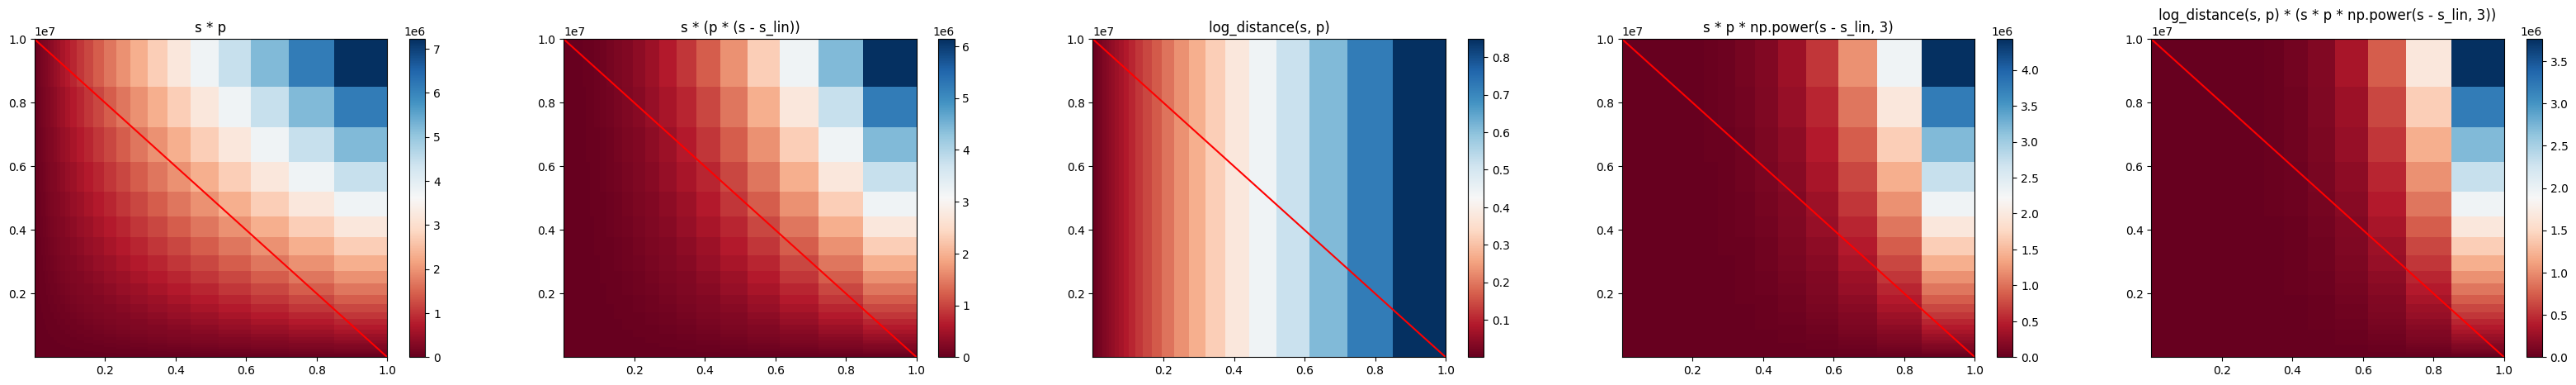

In [6]:
s, p = np.meshgrid(np.logspace(-7, 0, 100), np.logspace(0, 7, 100))

# z = jax.vmap(log_distance)(s=s, p=p) * calc_robustness(s=s, p=p, s_weight=10)
def plot_cmesh(z, ztext, iplot, ncol, nrow):
    z = z[:-1, :-1]
    z_min, z_max = np.abs(z).min(), np.abs(z).max()

    ax = plt.subplot(nrow, ncol, iplot)

    c = ax.pcolormesh(s, p, z, cmap='RdBu', vmin=z_min, vmax=z_max)
    ax.set_title('pcolormesh')
    ax.axis([s.min(), s.max(), p.min(), p.max()])
    fig.colorbar(c, ax=ax)
    
    plt.title(ztext)

    plt.plot(np.logspace(-7, 0, 2), np.logspace(7, 0, 2), 'r')
    # plt.xscale('log')
    # plt.yscale('log')

s_lin = 1/p
z1 = s * p
z2 = s * (p * (s - s_lin))
z3 = jax.vmap(log_distance)(s, p)
z4 = s * p * np.power(s - s_lin, 3)
z5 = jax.vmap(log_distance)(s, p) * (s * p * np.power(s - s_lin, 3))
zs = [z1, z2, z3, z4, z5]
ztexts = ['s * p', 's * (p * (s - s_lin))', 'log_distance(s, p)', 's * p * np.power(s - s_lin, 3)', 'log_distance(s, p) * (s * p * np.power(s - s_lin, 3))']

ncol = len(zs)
nrow = 1
fig = plt.figure(figsize=(8*ncol, 5*nrow))

for i, (zi, zt) in enumerate(zip(zs, ztexts)):
    plot_cmesh(zi, zt, i+1, ncol, nrow)

# plt.show()

In [7]:
def robustness(s, p, s_skew: int = 1):
    # s, p = np.log10(s), np.log10(p)
    s_lin = 1/p
    return s * p * np.power(s - s_lin, s_skew)
    

In [8]:
# np.log10(np.power(data['sensitivity_wrt_species-6'], 2)) / (np.log10(np.sqrt(data['precision_wrt_species-6'])) / 100)
data['robustness'] = robustness(data['sensitivity_wrt_species-6'].to_numpy(), data['precision_wrt_species-6'].to_numpy(), s_skew=5)

/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='robustness', ylabel='Count'>

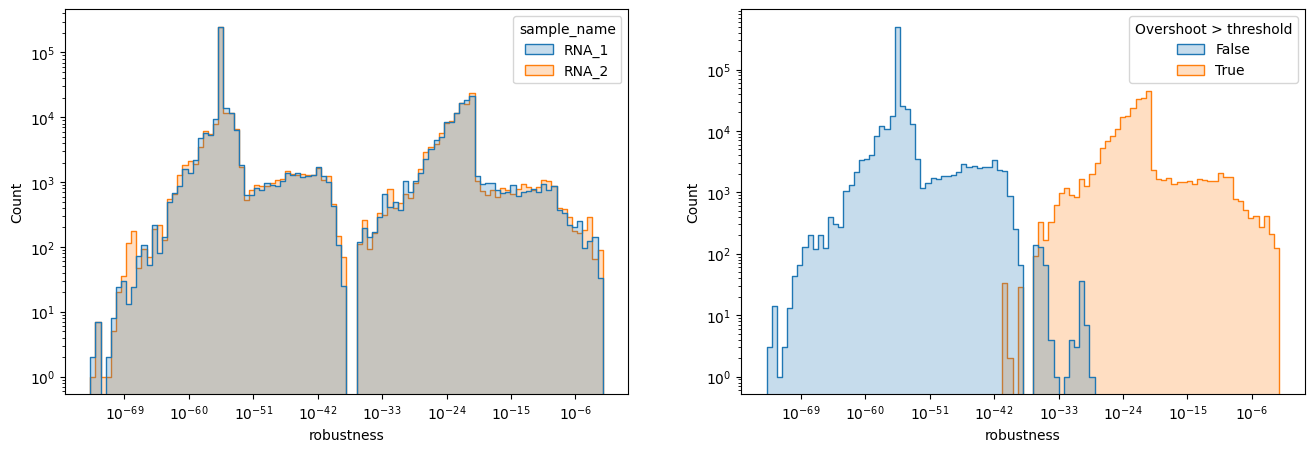

In [15]:
fig = plt.figure(figsize=(8*2, 5))
ax = plt.subplot(1,2,1)
sns.histplot(data[data['sample_name'] != 'RNA_0'], x='robustness', bins=100, element='step', hue='sample_name', log_scale=[True, True])
ax = plt.subplot(1,2,2)
sns.histplot(data[data['sample_name'] != 'RNA_0'], x='robustness', bins=100, element='step', hue='Overshoot > threshold', log_scale=[True, True])


/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='precision_wrt_species-6', ylabel='robustness'>

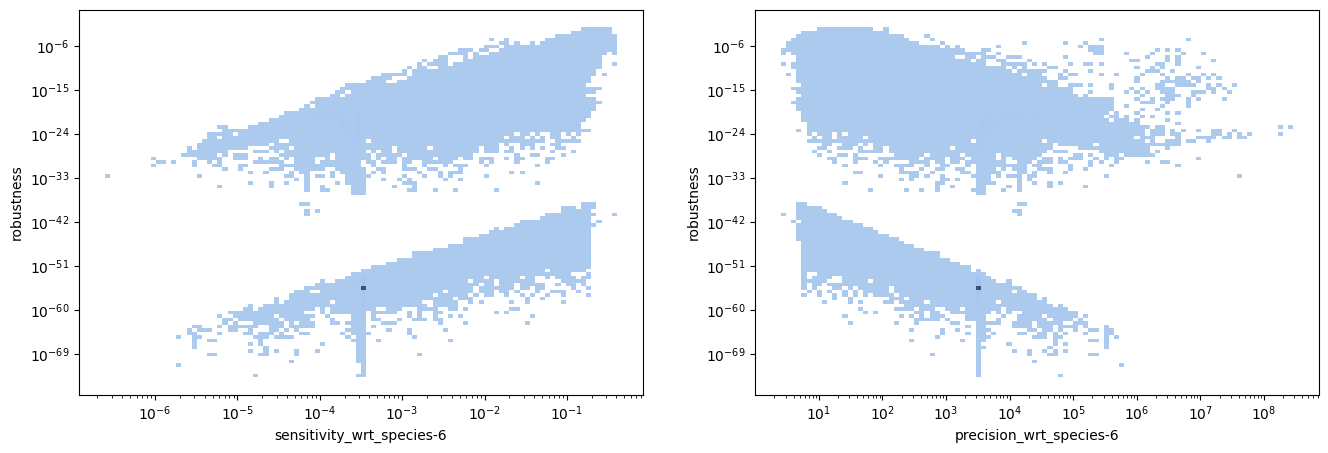

In [10]:
fig = plt.figure(figsize=(8*2, 5))
ax = plt.subplot(1,2,1)
sns.histplot(data[data['sample_name'] != 'RNA_0'], y='robustness', x='sensitivity_wrt_species-6', bins=100, element='step', log_scale=[True, True])
ax = plt.subplot(1,2,2)
sns.histplot(data[data['sample_name'] != 'RNA_0'], y='robustness', x='precision_wrt_species-6', bins=100, element='step', log_scale=[True, True])

/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 0.98, 'Overshoot threshold = 1e-05')

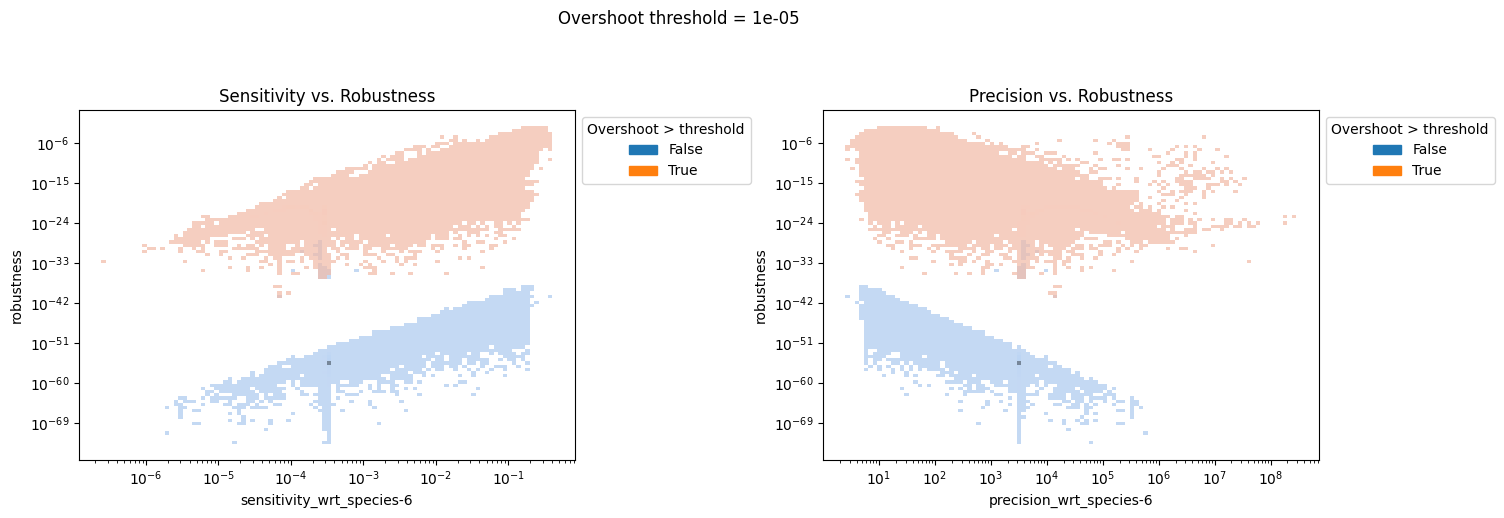

In [12]:
p = 1e-5

fig = plt.figure(figsize=(8*2, 5*2))
fig.subplots_adjust(wspace=0.5)

ax = plt.subplot(2,2,1)
data['Overshoot > threshold'] = data['overshoot'] > p
ax = sns.histplot(data[data['sample_name'] != 'RNA_0'], y='robustness', x='sensitivity_wrt_species-6', hue='Overshoot > threshold', bins=100, element='step', log_scale=[True, True], alpha=0.7)
plt.title('Sensitivity vs. Robustness')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
ax = plt.subplot(2,2,2)
sns.histplot(data[data['sample_name'] != 'RNA_0'], y='robustness', x='precision_wrt_species-6', hue='Overshoot > threshold', bins=100, element='step', log_scale=[True, True], alpha=0.7)
plt.title('Precision vs. Robustness')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
# ax = plt.subplot(2,2,3)
# sns.histplot(data[(data['sample_name'] != 'RNA_0') & (data['overshoot'] <= p)], y='robustness', x='sensitivity_wrt_species-6', bins=100, element='step', log_scale=[True, True])
# plt.title(f'Overshoot == {p}')
# ax = plt.subplot(2,2,4)
# sns.histplot(data[(data['sample_name'] != 'RNA_0') & (data['overshoot'] <= p)], y='robustness', x='precision_wrt_species-6', bins=100, element='step', log_scale=[True, True])
# plt.title(f'Overshoot == {p}')

plt.suptitle(f'Overshoot threshold = {p}')

/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='overshoot', ylabel='robustness'>

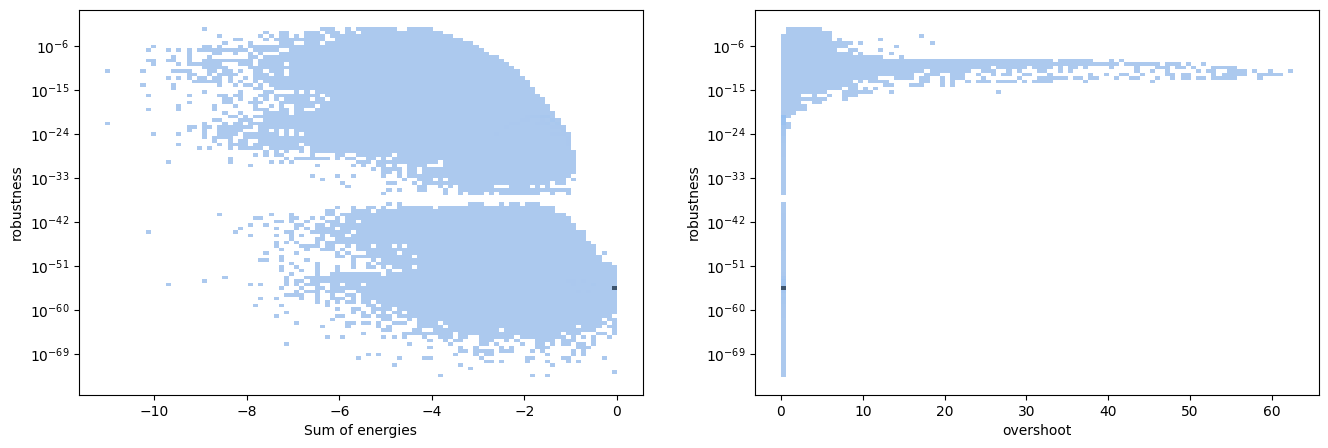

In [81]:
fig = plt.figure(figsize=(8*2, 5))
ax = plt.subplot(1,2,1)
sns.histplot(data[data['sample_name'] != 'RNA_0'], y='robustness', x=data[data['sample_name'] != 'RNA_0'][get_true_interaction_cols(data, 'energies', remove_symmetrical=True)].mean(axis=1), bins=100, element='step', log_scale=[False, True])
plt.xlabel('Sum of energies')
ax = plt.subplot(1,2,2)
sns.histplot(data[data['sample_name'] != 'RNA_0'], y='robustness', x='overshoot', bins=100, element='step', log_scale=[False, True])

<Axes: xlabel='energies', ylabel='Count'>

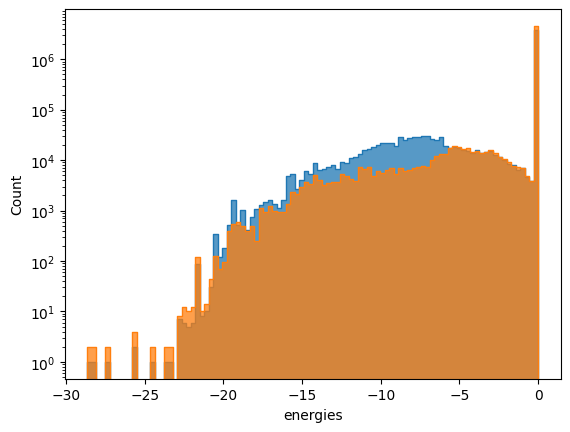

In [102]:
sns.histplot(data[data['robustness'] > 1e-35].melt(value_vars=get_true_interaction_cols(data, 'energies', remove_symmetrical=True), value_name='energies'), x='energies', element='step', bins=100, log_scale=[False, True])
sns.histplot(data[data['robustness'] <= 1e-35].melt(value_vars=get_true_interaction_cols(data, 'energies', remove_symmetrical=True), value_name='energies'), x='energies', element='step', bins=100, log_scale=[False, True])

In [16]:
np.sum(data[data['robustness'] > 1e-35].melt(value_vars=get_true_interaction_cols(data, 'energies', remove_symmetrical=True), value_name='energies')['energies'])

-6470170.690000003

/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/matplotlib/colors.py:1371: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)
/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/matplotlib/colors.py:1371: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)


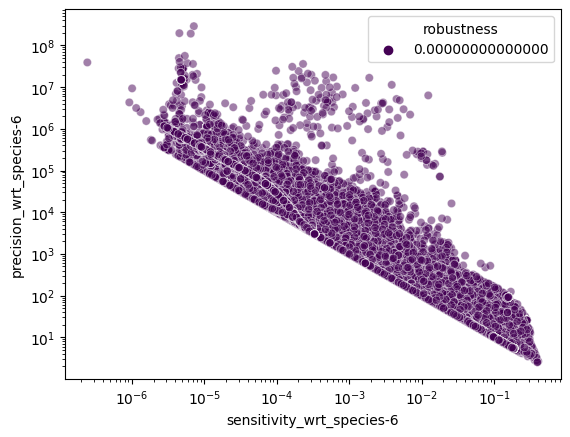

In [17]:
sns.scatterplot(data=data[data['sample_name'] != 'RNA_0'], x='sensitivity_wrt_species-6', 
                y='precision_wrt_species-6', hue=np.log10(data[data['sample_name'] != 'RNA_0']['robustness']), palette='viridis', alpha=0.5)
plt.xscale('log')
plt.yscale('log')

## Very that the traces ranking high on robustness are actually robust-looking

In [ ]:
config = load_json_as_dict(os.path.join(fn.split('summarise')[
                           0], 'mutation_effect_on_interactions_signal', 'experiment.json'))
config = config['config_filepath']
config['experiment']['purpose'] = 'tests'
config['simulation']['device'] = 'gpu'

jax.devices()
config['simulation']['dt0'] = config['simulation']['dt']
config['simulation']['threshold_steady_states'] = 0.1
config['experiment']['no_numerical'] = False
config['experiment']['no_visualisations'] = True

config, data_writer = script_preamble(prepare_config(config))

modeller = CircuitModeller(data_writer, config)

In [ ]:
def simulate(circuits: list, modeller: CircuitModeller, config: dict) -> list:
    
    circuits = modeller.batch_circuits(
        circuits=circuits,
        write_to_subsystem=True,
        batch_size=config['simulation'].get('batch_size', 100),
        methods={
            "compute_interactions": {},
            "init_circuits": {'batch': True},
            "simulate_signal_batch": {'ref_circuit': None,
                                      'batch': config['simulation']['use_batch_mutations']},
            "write_results": {'no_visualisations': config['experiment']['no_visualisations'],
                              'no_numerical': config['experiment']['no_numerical']}
        }
    )
    
    return circuits

    